<a href="https://colab.research.google.com/github/wjficap/wavefront/blob/main/3x%5ENDX_macd_strat_v190924a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dropdown(description='Start Year:', options=(1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995,…

Dropdown(description='Start Month:', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12), value=1)

Dropdown(description='Start Day:', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,…

Dropdown(description='End Year:', index=39, options=(1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 199…

Dropdown(description='End Month:', index=11, options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12), value=12)

Dropdown(description='End Day:', index=30, options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,…

[*********************100%***********************]  1 of 1 completed


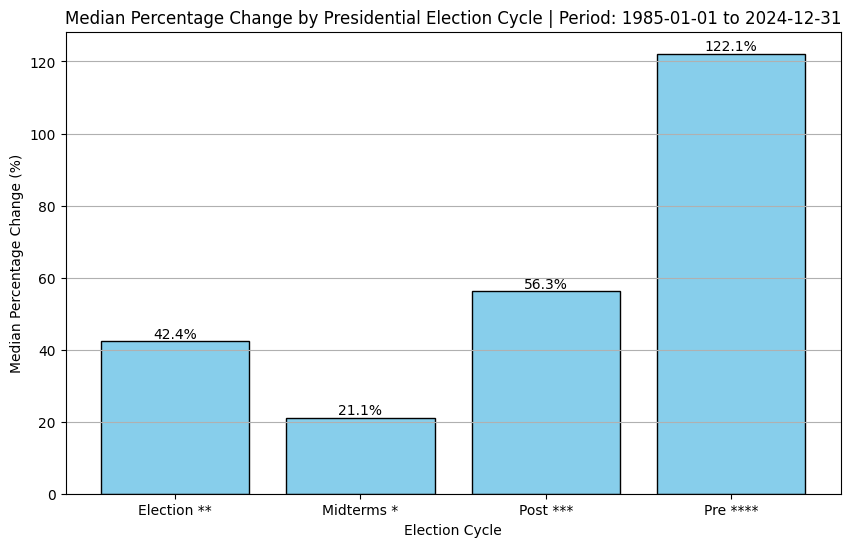

   Start Date   End Date Election Cycle  % Change  Value ($1k)
0  1985-10-14 1986-02-26     Midterms *      92.0         3841
1  1986-10-01 1987-07-24       Pre ****     160.7        10011
2  1987-11-04 1988-10-05    Election **      50.0        15019
3  1988-10-19 1989-07-24       Post ***      56.3        23476
4  1989-11-13 1990-01-11     Midterms *     -12.5        20532
5  1990-10-01 1991-08-19       Pre ****     219.2        65548
6  1991-10-15 1992-07-27    Election **       3.2        67663
7  1992-10-16 1993-07-30       Post ***      34.1        90767
8  1993-10-14 1994-01-25     Midterms *      14.2       103629
9  1994-10-12 1995-07-19       Pre ****     137.7       246370
10 1995-10-17 1996-08-29    Election **      39.7       344088
11 1996-10-14 1997-08-08       Post ***     168.4       923683
12 1997-10-06 1998-03-03     Midterms *       2.3       945386
13 1998-10-15 1999-07-20       Pre ****     406.5      4788644
14 1999-10-07 2000-07-24    Election **      80.8      

In [2]:
# @title Oct-July / MidTerm Oct-Jan / v2 {"vertical-output":true}

import ipywidgets as widgets
from IPython.display import display, clear_output
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Define dropdowns for year, month, and day
years = list(range(1985, 2025))
months = list(range(1, 13))
days = list(range(1, 32))


year_start = widgets.Dropdown(
    options=years,
    value=2015,
    description='Start Year:',
)

month_start = widgets.Dropdown(
    options=months,
    value=1,
    description='Start Month:',
)

day_start = widgets.Dropdown(
    options=days,
    value=1,
    description='Start Day:',
)

year_end = widgets.Dropdown(
    options=years,
    value=2024,
    description='End Year:',
)

month_end = widgets.Dropdown(
    options=months,
    value=12,
    description='End Month:',
)

day_end = widgets.Dropdown(
    options=days,
    value=31,
    description='End Day:',
)

# Function to handle date range updates
def update_data(change):
    clear_output(wait=True)
    display(year_start, month_start, day_start, year_end, month_end, day_end)  # Re-display widgets

    start_date = f'{year_start.value}-{month_start.value:02d}-{day_start.value:02d}'
    end_date = f'{year_end.value}-{month_end.value:02d}-{day_end.value:02d}'

    # Download data from Yahoo Finance
    data = yf.download('^NDX', start=start_date, end=end_date)
    data['Date'] = data.index
    data.reset_index(drop=True, inplace=True)

    # Calculate daily returns and 3x leverage
    data['Daily Return'] = data['Close'].pct_change()  # Daily return of ^NDX
    data['Leverage 3x Return'] = data['Daily Return'] * 3  # Applying 3x leverage

    # Calculate MACD
    def calculate_macd(df, slow=26, fast=12, signal=9):
        df['EMA_12'] = df['Close'].ewm(span=fast, adjust=False).mean()
        df['EMA_26'] = df['Close'].ewm(span=slow, adjust=False).mean()
        df['MACD'] = df['EMA_12'] - df['EMA_26']
        df['Signal_Line'] = df['MACD'].ewm(span=signal, adjust=False).mean()
        return df

    data = calculate_macd(data)

    # Identify MACD crossovers
    data['MACD_Crossover'] = np.where(
        (data['MACD'] > data['Signal_Line']) & (data['MACD'].shift(1) <= data['Signal_Line'].shift(1)), 'Bullish',
        np.where((data['MACD'] < data['Signal_Line']) & (data['MACD'].shift(1) >= data['Signal_Line'].shift(1)), 'Bearish', np.nan)
    )

    # Step 7: Add presidential election cycle
    def election_cycle(year):
        cycle_year = year % 4
        if cycle_year == 0:
            return 'Election **'
        elif cycle_year == 1:
            return 'Post ***'
        elif cycle_year == 2:
            return 'Midterms *'
        else:
            return 'Pre ****'

    # Find the start and end crossover periods
    def find_crossover_periods(df):
        start_dates = []
        end_dates = []

        min_year = df['Date'].dt.year.min()
        max_year = df['Date'].dt.year.max()

        for year in range(min_year, max_year):
            current_cycle = election_cycle(year)

            if current_cycle == 'Post ***':
                start_filter = df[(df['Date'] >= pd.Timestamp(f'{year}-10-01')) & (df['MACD_Crossover'] == 'Bullish')]
                if not start_filter.empty:
                    start_date = start_filter.iloc[0]['Date']
                    end_filter = df[(df['Date'] >= pd.Timestamp(f'{year+1}-01-01')) & (df['MACD_Crossover'] == 'Bearish')]
                    if not end_filter.empty:
                        end_date = end_filter.iloc[0]['Date']
                        start_dates.append(start_date)
                        end_dates.append(end_date)
            else:
                start_filter = df[(df['Date'] >= pd.Timestamp(f'{year}-10-01')) & (df['MACD_Crossover'] == 'Bullish')]
                if not start_filter.empty:
                    start_date = start_filter.iloc[0]['Date']
                    end_filter = df[(df['Date'] >= pd.Timestamp(f'{year+1}-07-15')) & (df['MACD_Crossover'] == 'Bearish')]
                    if not end_filter.empty:
                        end_date = end_filter.iloc[0]['Date']
                        start_dates.append(start_date)
                        end_dates.append(end_date)

        return pd.DataFrame({'Start Date': start_dates, 'End Date': end_dates})

    macd_periods = find_crossover_periods(data)

    # Add presidential election cycle
    macd_periods['Election Cycle'] = macd_periods['End Date'].dt.year.apply(election_cycle)

    # Calculate percentage changes with 3x leverage
    percentage_changes_leveraged = []
    funds_leveraged = [2000]  # Initial fund value of $1000 for leveraged investment
    initial_fund_leveraged = 2000  # Adjusted initial fund value to $1,000

    for index, row in macd_periods.iterrows():
        start_date = row['Start Date']
        end_date = row['End Date']

        period_data = data[(data['Date'] >= start_date) & (data['Date'] <= end_date)]

        cumulative_return = (1 + period_data['Leverage 3x Return']).prod() - 1
        percentage_changes_leveraged.append(cumulative_return * 100)

        initial_fund_leveraged *= (1 + cumulative_return)
        funds_leveraged.append(initial_fund_leveraged)

    macd_periods['% Change'] = percentage_changes_leveraged
    macd_periods['Value ($1k)'] = funds_leveraged[1:]

    macd_periods['% Change'] = macd_periods['% Change'].round(1)
    macd_periods['Value ($1k)'] = macd_periods['Value ($1k)'].round(0).astype(int)

    # Aggregate returns by election cycle
    cycle_returns = macd_periods.groupby('Election Cycle')['% Change'].median().reset_index()

    # Plot bar chart
    plt.figure(figsize=(10, 6))
    bars = plt.bar(cycle_returns['Election Cycle'], cycle_returns['% Change'], color='skyblue', edgecolor='black')
    plt.xlabel('Election Cycle')
    plt.ylabel('Median Percentage Change (%)')
    chart_title = f'Median Percentage Change by Presidential Election Cycle | Period: {year_start.value}-{month_start.value:02d}-{day_start.value:02d} to {year_end.value}-{month_end.value:02d}-{day_end.value:02d}'
    plt.title(chart_title)
    plt.grid(axis='y')

    # Add percentage values on top of each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.1f}%', va='bottom', ha='center')

    plt.show()


    # Output the table with leverage results
    print(macd_periods)

    # Optional: Export to CSV
    macd_periods.to_csv('macd_periods_leveraged.csv', index=False)

# Link widgets to update function
year_start.observe(update_data, names='value')
month_start.observe(update_data, names='value')
day_start.observe(update_data, names='value')
year_end.observe(update_data, names='value')
month_end.observe(update_data, names='value')
day_end.observe(update_data, names='value')

# Display widgets
display(year_start, month_start, day_start, year_end, month_end, day_end)


In [ ]:
# @title Oct-July / MidTerm Oct-Jan / v3 (2 charts) {"vertical-output":true}
import ipywidgets as widgets
from IPython.display import display, clear_output
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Define dropdowns for year, month, and day for two different date ranges
years = list(range(1985, 2025))
months = list(range(1, 13))
days = list(range(1, 32))

# Widgets for the first date range
year_start1 = widgets.Dropdown(
    options=years,
    value=1985,
    description='Start Year 1:',
)

month_start1 = widgets.Dropdown(
    options=months,
    value=1,
    description='Start Month 1:',
)

day_start1 = widgets.Dropdown(
    options=days,
    value=1,
    description='Start Day 1:',
)

year_end1 = widgets.Dropdown(
    options=years,
    value=2000,
    description='End Year 1:',
)

month_end1 = widgets.Dropdown(
    options=months,
    value=12,
    description='End Month 1:',
)

day_end1 = widgets.Dropdown(
    options=days,
    value=31,
    description='End Day 1:',
)

# Widgets for the second date range
year_start2 = widgets.Dropdown(
    options=years,
    value=2000,
    description='Start Year 2:',
)

month_start2 = widgets.Dropdown(
    options=months,
    value=1,
    description='Start Month 2:',
)

day_start2 = widgets.Dropdown(
    options=days,
    value=1,
    description='Start Day 2:',
)

year_end2 = widgets.Dropdown(
    options=years,
    value=2024,
    description='End Year 2:',
)

month_end2 = widgets.Dropdown(
    options=months,
    value=12,
    description='End Month 2:',
)

day_end2 = widgets.Dropdown(
    options=days,
    value=31,
    description='End Day 2:',
)

# Function to handle date range updates for plotting
def update_data(change):
    clear_output(wait=True)
    display(year_start1, month_start1, day_start1, year_end1, month_end1, day_end1,
            year_start2, month_start2, day_start2, year_end2, month_end2, day_end2)  # Re-display widgets

    # Simulation 1
    start_date1 = f'{year_start1.value}-{month_start1.value:02d}-{day_start1.value:02d}'
    end_date1 = f'{year_end1.value}-{month_end1.value:02d}-{day_end1.value:02d}'

    # Download data from Yahoo Finance
    data1 = yf.download('^NDX', start=start_date1, end=end_date1)
    data1['Date'] = data1.index
    data1.reset_index(drop=True, inplace=True)

    # Calculate daily returns and 3x leverage
    data1['Daily Return'] = data1['Close'].pct_change()
    data1['Leverage 3x Return'] = data1['Daily Return'] * 3

    # Calculate MACD
    data1 = calculate_macd(data1)

    # Identify MACD crossovers
    data1['MACD_Crossover'] = np.where(
        (data1['MACD'] > data1['Signal_Line']) & (data1['MACD'].shift(1) <= data1['Signal_Line'].shift(1)), 'Bullish',
        np.where((data1['MACD'] < data1['Signal_Line']) & (data1['MACD'].shift(1) >= data1['Signal_Line'].shift(1)), 'Bearish', np.nan)
    )

    # Find crossover periods
    macd_periods1 = find_crossover_periods(data1)

    # Add presidential election cycle
    macd_periods1['Election Cycle'] = macd_periods1['End Date'].dt.year.apply(election_cycle)

    # Calculate percentage changes with 3x leverage
    percentage_changes_leveraged1 = []
    funds_leveraged1 = [1000]
    initial_fund_leveraged1 = 1000

    for index, row in macd_periods1.iterrows():
        start_date = row['Start Date']
        end_date = row['End Date']

        period_data = data1[(data1['Date'] >= start_date) & (data1['Date'] <= end_date)]

        cumulative_return = (1 + period_data['Leverage 3x Return']).prod() - 1
        percentage_changes_leveraged1.append(cumulative_return * 100)

        initial_fund_leveraged1 *= (1 + cumulative_return)
        funds_leveraged1.append(initial_fund_leveraged1)

    macd_periods1['% Change'] = percentage_changes_leveraged1
    macd_periods1['Value ($1k)'] = funds_leveraged1[1:]

    macd_periods1['% Change'] = macd_periods1['% Change'].round(1)
    macd_periods1['Value ($1k)'] = macd_periods1['Value ($1k)'].round(0).astype(int)

    # Aggregate returns by election cycle
    cycle_returns1 = macd_periods1.groupby('Election Cycle')['% Change'].median().reset_index()

    # Plot chart for Simulation 1
    plt.figure(figsize=(10, 6))
    bars1 = plt.bar(cycle_returns1['Election Cycle'], cycle_returns1['% Change'], color='skyblue', edgecolor='black')
    plt.xlabel('Election Cycle')
    plt.ylabel('Median Percentage Change (%)')
    plt.title(f'Median Percentage Change by Presidential Election Cycle | Simulation 1: {start_date1} to {end_date1}')
    plt.grid(axis='y')

    for bar in bars1:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.1f}%', va='bottom', ha='center')

    plt.show()

    # Simulation 2
    start_date2 = f'{year_start2.value}-{month_start2.value:02d}-{day_start2.value:02d}'
    end_date2 = f'{year_end2.value}-{month_end2.value:02d}-{day_end2.value:02d}'

    # Download data from Yahoo Finance
    data2 = yf.download('^NDX', start=start_date2, end=end_date2)
    data2['Date'] = data2.index
    data2.reset_index(drop=True, inplace=True)

    # Calculate daily returns and 3x leverage
    data2['Daily Return'] = data2['Close'].pct_change()
    data2['Leverage 3x Return'] = data2['Daily Return'] * 3

    # Calculate MACD
    data2 = calculate_macd(data2)

    # Identify MACD crossovers
    data2['MACD_Crossover'] = np.where(
        (data2['MACD'] > data2['Signal_Line']) & (data2['MACD'].shift(1) <= data2['Signal_Line'].shift(1)), 'Bullish',
        np.where((data2['MACD'] < data2['Signal_Line']) & (data2['MACD'].shift(1) >= data2['Signal_Line'].shift(1)), 'Bearish', np.nan)
    )

    # Find crossover periods
    macd_periods2 = find_crossover_periods(data2)

    # Add presidential election cycle
    macd_periods2['Election Cycle'] = macd_periods2['End Date'].dt.year.apply(election_cycle)

    # Calculate percentage changes with 3x leverage
    percentage_changes_leveraged2 = []
    funds_leveraged2 = [1000]
    initial_fund_leveraged2 = 1000

    for index, row in macd_periods2.iterrows():
        start_date = row['Start Date']
        end_date = row['End Date']

        period_data = data2[(data2['Date'] >= start_date) & (data2['Date'] <= end_date)]

        cumulative_return = (1 + period_data['Leverage 3x Return']).prod() - 1
        percentage_changes_leveraged2.append(cumulative_return * 100)

        initial_fund_leveraged2 *= (1 + cumulative_return)
        funds_leveraged2.append(initial_fund_leveraged2)

    macd_periods2['% Change'] = percentage_changes_leveraged2
    macd_periods2['Value ($1k)'] = funds_leveraged2[1:]

    macd_periods2['% Change'] = macd_periods2['% Change'].round(1)

# Helper functions
def calculate_macd(df, slow=26, fast=12, signal=9):
    df['EMA_12'] = df['Close'].ewm(span=fast, adjust=False).mean()
    df['EMA_26'] = df['Close'].ewm(span=slow, adjust=False).mean()
    df['MACD'] = df['EMA_12'] - df['EMA_26']
    df['Signal_Line'] = df['MACD'].ewm(span=signal, adjust=False).mean()
    return df

def election_cycle(year):
    cycle_year = year % 4
    if cycle_year == 0:
        return 'Election **'
    elif cycle_year == 1:
        return 'Post ***'
    elif cycle_year == 2:
        return 'Midterms *'
    else:
        return 'Pre ****'

def find_crossover_periods(df):
    start_dates = []
    end_dates = []

    min_year = df['Date'].dt.year.min()
    max_year = df['Date'].dt.year.max()

    for year in range(min_year, max_year):
        current_cycle = election_cycle(year)

        if current_cycle == 'Post ***':
            start_filter = df[(df['Date'] >= pd.Timestamp(f'{year}-10-01')) & (df['MACD_Crossover'] == 'Bullish')]
            if not start_filter.empty:
                start_date = start_filter.iloc[0]['Date']
                end_filter = df[(df['Date'] >= pd.Timestamp(f'{year+1}-01-01')) & (df['MACD_Crossover'] == 'Bearish')]
                if not end_filter.empty:
                    end_date = end_filter.iloc[0]['Date']
                    start_dates.append(start_date)
                    end_dates.append(end_date)
        else:
            start_filter = df[(df['Date'] >= pd.Timestamp(f'{year}-10-01')) & (df['MACD_Crossover'] == 'Bullish')]
            if not start_filter.empty:
                start_date = start_filter.iloc[0]['Date']
                end_filter = df[(df['Date'] >= pd.Timestamp(f'{year+1}-07-17')) & (df['MACD_Crossover'] == 'Bearish')]
                if not end_filter.empty:
                    end_date = end_filter.iloc[0]['Date']
                    start_dates.append(start_date)
                    end_dates.append(end_date)

    return pd.DataFrame({'Start Date': start_dates, 'End Date': end_dates})

# Update data function with two simulations
def update_data(change):
    clear_output(wait=True)
    display(year_start1, month_start1, day_start1, year_end1, month_end1, day_end1,
            year_start2, month_start2, day_start2, year_end2, month_end2, day_end2)  # Re-display widgets

    # Simulation 1
    start_date1 = f'{year_start1.value}-{month_start1.value:02d}-{day_start1.value:02d}'
    end_date1 = f'{year_end1.value}-{month_end1.value:02d}-{day_end1.value:02d}'

    try:
        data1 = yf.download('^NDX', start=start_date1, end=end_date1)
        data1['Date'] = data1.index
        data1.reset_index(drop=True, inplace=True)
        data1['Daily Return'] = data1['Close'].pct_change()
        data1['Leverage 3x Return'] = data1['Daily Return'] * 3
        data1 = calculate_macd(data1)
        data1['MACD_Crossover'] = np.where(
            (data1['MACD'] > data1['Signal_Line']) & (data1['MACD'].shift(1) <= data1['Signal_Line'].shift(1)), 'Bullish',
            np.where((data1['MACD'] < data1['Signal_Line']) & (data1['MACD'].shift(1) >= data1['Signal_Line'].shift(1)), 'Bearish', np.nan)
        )
        macd_periods1 = find_crossover_periods(data1)
        macd_periods1['Election Cycle'] = macd_periods1['End Date'].dt.year.apply(election_cycle)

        percentage_changes_leveraged1 = []
        funds_leveraged1 = [1000]
        initial_fund_leveraged1 = 1000

        for index, row in macd_periods1.iterrows():
            start_date = row['Start Date']
            end_date = row['End Date']

            period_data = data1[(data1['Date'] >= start_date) & (data1['Date'] <= end_date)]

            cumulative_return = (1 + period_data['Leverage 3x Return']).prod() - 1
            percentage_changes_leveraged1.append(cumulative_return * 100)

            initial_fund_leveraged1 *= (1 + cumulative_return)
            funds_leveraged1.append(initial_fund_leveraged1)

        macd_periods1['% Change'] = percentage_changes_leveraged1
        macd_periods1['Value ($1k)'] = funds_leveraged1[1:]

        macd_periods1['% Change'] = macd_periods1['% Change'].round(1)
        macd_periods1['Value ($1k)'] = macd_periods1['Value ($1k)'].round(0).astype(int)

        cycle_returns1 = macd_periods1.groupby('Election Cycle')['% Change'].median().reset_index()

        # Plot chart for Simulation 1
        plt.figure(figsize=(10, 6))
        bars1 = plt.bar(cycle_returns1['Election Cycle'], cycle_returns1['% Change'], color='skyblue', edgecolor='black')
        plt.xlabel('Election Cycle')
        plt.ylabel('Median Percentage Change (%)')
        plt.title(f'Median Percentage Change by Presidential Election Cycle | Simulation 1: {start_date1} to {end_date1}')
        plt.grid(axis='y')

        for bar in bars1:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.1f}%', va='bottom', ha='center')

        plt.show()

    except Exception as e:
        print(f"An error occurred during Simulation 1: {e}")

    # Simulation 2
    start_date2 = f'{year_start2.value}-{month_start2.value:02d}-{day_start2.value:02d}'
    end_date2 = f'{year_end2.value}-{month_end2.value:02d}-{day_end2.value:02d}'

    try:
        data2 = yf.download('^NDX', start=start_date2, end=end_date2)
        data2['Date'] = data2.index
        data2.reset_index(drop=True, inplace=True)
        data2['Daily Return'] = data2['Close'].pct_change()
        data2['Leverage 3x Return'] = data2['Daily Return'] * 3
        data2 = calculate_macd(data2)
        data2['MACD_Crossover'] = np.where(
            (data2['MACD'] > data2['Signal_Line']) & (data2['MACD'].shift(1) <= data2['Signal_Line'].shift(1)), 'Bullish',
            np.where((data2['MACD'] < data2['Signal_Line']) & (data2['MACD'].shift(1) >= data2['Signal_Line'].shift(1)), 'Bearish', np.nan)
        )
        macd_periods2 = find_crossover_periods(data2)
        macd_periods2['Election Cycle'] = macd_periods2['End Date'].dt.year.apply(election_cycle)

        percentage_changes_leveraged2 = []
        funds_leveraged2 = [1000]
        initial_fund_leveraged2 = 1000

        for index, row in macd_periods2.iterrows():
            start_date = row['Start Date']
            end_date = row['End Date']

            period_data = data2[(data2['Date'] >= start_date) & (data2['Date'] <= end_date)]

            cumulative_return = (1 + period_data['Leverage 3x Return']).prod() - 1
            percentage_changes_leveraged2.append(cumulative_return * 100)

            initial_fund_leveraged2 *= (1 + cumulative_return)
            funds_leveraged2.append(initial_fund_leveraged2)

        macd_periods2['% Change'] = percentage_changes_leveraged2
        macd_periods2['Value ($1k)'] = funds_leveraged2[1:]

        macd_periods2['% Change'] = macd_periods2['% Change'].round(1)
        macd_periods2['Value ($1k)'] = macd_periods2['Value ($1k)'].round(0).astype(int)

        cycle_returns2 = macd_periods2.groupby('Election Cycle')['% Change'].median().reset_index()

        # Plot chart for Simulation 2
        plt.figure(figsize=(10, 6))
        bars2 = plt.bar(cycle_returns2['Election Cycle'], cycle_returns2['% Change'], color='lightgreen', edgecolor='black')
        plt.xlabel('Election Cycle')
        plt.ylabel('Median Percentage Change (%)')
        plt.title(f'Median Percentage Change by Presidential Election Cycle | Simulation 2: {start_date2} to {end_date2}')
        plt.grid(axis='y')

        for bar in bars2:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.1f}%', va='bottom', ha='center')

        plt.show()

    except Exception as e:
        print(f"An error occurred during Simulation 2: {e}")

    # Output the tables with leverage results
    print("Simulation 1 Results:")
    print(macd_periods1)

    print("Simulation 2 Results:")
    print(macd_periods2)

    # Optional: Export to CSV
    macd_periods1.to_csv('macd_periods_leveraged1.csv', index=False)
    macd_periods2.to_csv('macd_periods_leveraged2.csv', index=False)

# Link widgets to update function
year_start1.observe(update_data, names='value')
month_start1.observe(update_data, names='value')
day_start1.observe(update_data, names='value')
year_end1.observe(update_data, names='value')
month_end1.observe(update_data, names='value')
day_end1.observe(update_data, names='value')

year_start2.observe(update_data, names='value')
month_start2.observe(update_data, names='value')
day_start2.observe(update_data, names='value')
year_end2.observe(update_data, names='value')
month_end2.observe(update_data, names='value')
day_end2.observe(update_data, names='value')

# Display widgets
display(year_start1, month_start1, day_start1, year_end1, month_end1, day_end1,
        year_start2, month_start2, day_start2, year_end2, month_end2, day_end2)


In [ ]:
# @title Oct-July / Midterms Oct-Jan {"vertical-output":true}
# Import libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Step 1: Download data from Yahoo Finance
start_date = '2012-01-01'
end_date = '2024-12-31'

data = yf.download('^NDX', start=start_date, end=end_date)
data['Date'] = data.index
data.reset_index(drop=True, inplace=True)

# Step 2: Calculate daily returns and 3x leverage
data['Daily Return'] = data['Close'].pct_change()  # Daily return of ^NDX
data['Leverage 3x Return'] = data['Daily Return'] * 3  # Applying 3x leverage

# Step 3: Calculate MACD
def calculate_macd(df, slow=26, fast=12, signal=9):
    df['EMA_12'] = df['Close'].ewm(span=fast, adjust=False).mean()
    df['EMA_26'] = df['Close'].ewm(span=slow, adjust=False).mean()
    df['MACD'] = df['EMA_12'] - df['EMA_26']
    df['Signal_Line'] = df['MACD'].ewm(span=signal, adjust=False).mean()
    return df

data = calculate_macd(data)

# Step 4: Identify MACD crossovers
data['MACD_Crossover'] = np.where(
    (data['MACD'] > data['Signal_Line']) & (data['MACD'].shift(1) <= data['Signal_Line'].shift(1)), 'Bullish',
    np.where((data['MACD'] < data['Signal_Line']) & (data['MACD'].shift(1) >= data['Signal_Line'].shift(1)), 'Bearish', np.nan)
)

# Step 7: Add presidential election cycle
def election_cycle(year):
    cycle_year = year % 4
    if cycle_year == 0:
        return 'Election **'
    elif cycle_year == 1:
        return 'Post ***'
    elif cycle_year == 2:
        return 'Midterms *'
    else:
        return 'Pre ****'

# Step 5: Find the start (bullish) and end (bearish) crossovers based on the criteria
def find_crossover_periods(df):
    start_dates = []
    end_dates = []

    # Get the minimum and maximum years in the data
    min_year = df['Date'].dt.year.min()
    max_year = df['Date'].dt.year.max()

    for year in range(min_year, max_year):
        # Get the election cycle for the current year
        current_cycle = election_cycle(year)

        if current_cycle == 'Post ***':
            # Special case for Post-Election year
            start_filter = df[(df['Date'] >= pd.Timestamp(f'{year}-10-01')) & (df['MACD_Crossover'] == 'Bullish')]
            if not start_filter.empty:
                start_date = start_filter.iloc[0]['Date']
                # End period on January 1 of the midterm year
                end_filter = df[(df['Date'] >= pd.Timestamp(f'{year+1}-01-01')) & (df['MACD_Crossover'] == 'Bearish')]
                if not end_filter.empty:
                    end_date = end_filter.iloc[0]['Date']

                    # Append the start and end dates
                    start_dates.append(start_date)
                    end_dates.append(end_date)
        else:
            # Standard case
            start_filter = df[(df['Date'] >= pd.Timestamp(f'{year}-10-01')) & (df['MACD_Crossover'] == 'Bullish')]
            if not start_filter.empty:
                start_date = start_filter.iloc[0]['Date']

                # Now look for the bearish crossover after July 17 of the next year
                end_filter = df[(df['Date'] >= pd.Timestamp(f'{year+1}-07-17')) & (df['MACD_Crossover'] == 'Bearish')]
                if not end_filter.empty:
                    end_date = end_filter.iloc[0]['Date']

                    # Append the start and end dates
                    start_dates.append(start_date)
                    end_dates.append(end_date)

    return pd.DataFrame({'Start Date': start_dates, 'End Date': end_dates})

macd_periods = find_crossover_periods(data)

# Step 7: Add presidential election cycle


macd_periods['Election Cycle'] = macd_periods['End Date'].dt.year.apply(election_cycle)

# Step 6 (Revised): Calculate percentage changes with 3x leverage
percentage_changes_leveraged = []
funds_leveraged = [1000]  # Initial fund value of $1000 for leveraged investment
initial_fund_leveraged = 1000  # Adjusted initial fund value to $1,000

# Loop through the periods to calculate end-of-year fund values
for index, row in macd_periods.iterrows():
    start_date = row['Start Date']
    end_date = row['End Date']

    # Extract the returns within the specified period
    period_data = data[(data['Date'] >= start_date) & (data['Date'] <= end_date)]

    # Calculate cumulative return for 3x leveraged strategy
    cumulative_return = (1 + period_data['Leverage 3x Return']).prod() - 1
    percentage_changes_leveraged.append(cumulative_return * 100)

    # Update the fund value based on the leveraged cumulative return
    initial_fund_leveraged *= (1 + cumulative_return)
    funds_leveraged.append(initial_fund_leveraged)

# Align the fund value to the end of each period
macd_periods['% Change'] = percentage_changes_leveraged
macd_periods['Value ($1k)'] = funds_leveraged[1:]  # Move to the end of the year

# Round the percentage changes and investment values to 3 decimal places
macd_periods['% Change'] = macd_periods['% Change'].round(1)
macd_periods['Value ($1k)'] = macd_periods['Value ($1k)'].round(0).astype(int)



# Step 8 (Revised): Aggregate returns by election cycle using median
cycle_returns = macd_periods.groupby('Election Cycle')['% Change'].median().reset_index()

# Plot bar chart for median returns by election cycle
plt.figure(figsize=(10, 6))
plt.bar(cycle_returns['Election Cycle'], cycle_returns['% Change'], color='skyblue', edgecolor='black')
plt.xlabel('Election Cycle')
plt.ylabel('Median Percentage Change (%)')
plt.title('Median Percentage Change by Presidential Election Cycle')
plt.grid(axis='y')
plt.show()

# Step 9: Output the table with leverage results
print(macd_periods)

# Optional: Export to CSV
macd_periods.to_csv('macd_periods_leveraged.csv', index=False)

In [ ]:
# @title Oct-July / Original / Median
# Import libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Step 1: Download data from Yahoo Finance
start_date = '2003-01-01'
end_date = '2024-12-31'

data = yf.download('^NDX', start=start_date, end=end_date)
data['Date'] = data.index
data.reset_index(drop=True, inplace=True)

# Step 2: Calculate daily returns and 3x leverage
data['Daily Return'] = data['Close'].pct_change()  # Daily return of ^NDX
data['Leverage 3x Return'] = data['Daily Return'] * 3  # Applying 3x leverage

# Step 3: Calculate MACD
def calculate_macd(df, slow=26, fast=12, signal=9):
    df['EMA_12'] = df['Close'].ewm(span=fast, adjust=False).mean()
    df['EMA_26'] = df['Close'].ewm(span=slow, adjust=False).mean()
    df['MACD'] = df['EMA_12'] - df['EMA_26']
    df['Signal_Line'] = df['MACD'].ewm(span=signal, adjust=False).mean()
    return df

data = calculate_macd(data)

# Step 4: Identify MACD crossovers
data['MACD_Crossover'] = np.where(
    (data['MACD'] > data['Signal_Line']) & (data['MACD'].shift(1) <= data['Signal_Line'].shift(1)), 'Bullish',
    np.where((data['MACD'] < data['Signal_Line']) & (data['MACD'].shift(1) >= data['Signal_Line'].shift(1)), 'Bearish', np.nan)
)

# Step 5: Find the start (bullish) and end (bearish) crossovers based on the criteria
def find_crossover_periods(df):
    start_dates = []
    end_dates = []

    # Get the minimum and maximum years in the data
    min_year = df['Date'].dt.year.min()
    max_year = df['Date'].dt.year.max()

    for year in range(min_year, max_year):
        # Filter data to start searching from October 1 of the current year
        start_filter = df[(df['Date'] >= pd.Timestamp(f'{year}-10-01')) & (df['MACD_Crossover'] == 'Bullish')]
        if not start_filter.empty:
            start_date = start_filter.iloc[0]['Date']

            # Now look for the bearish crossover after July 17 of the next year
            end_filter = df[(df['Date'] >= pd.Timestamp(f'{year+1}-07-17')) & (df['MACD_Crossover'] == 'Bearish')]
            if not end_filter.empty:
                end_date = end_filter.iloc[0]['Date']

                # Append the start and end dates
                start_dates.append(start_date)
                end_dates.append(end_date)

    return pd.DataFrame({'Start Date': start_dates, 'End Date': end_dates})

macd_periods = find_crossover_periods(data)

# Step 6 (Revised): Calculate percentage changes with 3x leverage
percentage_changes_leveraged = []
funds_leveraged = [1000]  # Initial fund value of $575 for leveraged investment
initial_fund_leveraged = 1000  # Adjusted initial fund value to $1,000

# Loop through the periods to calculate end-of-year fund values
for index, row in macd_periods.iterrows():
    start_date = row['Start Date']
    end_date = row['End Date']

    # Extract the returns within the specified period
    period_data = data[(data['Date'] >= start_date) & (data['Date'] <= end_date)]

    # Calculate cumulative return for 3x leveraged strategy
    cumulative_return = (1 + period_data['Leverage 3x Return']).prod() - 1
    percentage_changes_leveraged.append(cumulative_return * 100)

    # Update the fund value based on the leveraged cumulative return
    initial_fund_leveraged *= (1 + cumulative_return)
    funds_leveraged.append(initial_fund_leveraged)

# Align the fund value to the end of each period
macd_periods['% Change'] = percentage_changes_leveraged
macd_periods['Value ($1k)'] = funds_leveraged[1:]  # Move to the end of the year

# Round the percentage changes and investment values to 3 decimal places
macd_periods['% Change'] = macd_periods['% Change'].round(1)
macd_periods['Value ($1k)'] = macd_periods['Value ($1k)'].round(0).astype(int)

# Step 7: Add presidential election cycle
def election_cycle(year):
    cycle_year = year % 4
    if cycle_year == 0:
        return 'Election **'
    elif cycle_year == 1:
        return 'Post ***'
    elif cycle_year == 2:
        return 'Midterms *'
    else:
        return 'Pre ****'

macd_periods['Election Cycle'] = macd_periods['End Date'].dt.year.apply(election_cycle)

# Step 8 (Revised): Aggregate returns by election cycle using median
cycle_returns = macd_periods.groupby('Election Cycle')['% Change'].median().reset_index()

# Plot bar chart for median returns by election cycle
plt.figure(figsize=(10, 6))
plt.bar(cycle_returns['Election Cycle'], cycle_returns['% Change'], color='skyblue', edgecolor='black')
plt.xlabel('Election Cycle')
plt.ylabel('Median Percentage Change (%)')
plt.title('Median Percentage Change by Presidential Election Cycle')
plt.grid(axis='y')
plt.show()

# Step 9: Output the table with leverage results
print(macd_periods)

# Optional: Export to CSV
macd_periods.to_csv('macd_periods_leveraged.csv', index=False)


In [ ]:
# @title Oct-July / Full Post Election Year / Median
# Import libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Step 1: Download data from Yahoo Finance
start_date = '1996-01-01'
end_date = '2024-12-31'
data = yf.download('^NDX', start=start_date, end=end_date)
data['Date'] = data.index
data.reset_index(drop=True, inplace=True)

# Step 2: Calculate daily returns and 3x leverage
data['Daily Return'] = data['Close'].pct_change()  # Daily return of ^NDX
data['Leverage 3x Return'] = data['Daily Return'] * 3  # Applying 3x leverage

# Step 3: Calculate MACD
def calculate_macd(df, slow=26, fast=12, signal=9):
    df['EMA_12'] = df['Close'].ewm(span=fast, adjust=False).mean()
    df['EMA_26'] = df['Close'].ewm(span=slow, adjust=False).mean()
    df['MACD'] = df['EMA_12'] - df['EMA_26']
    df['Signal_Line'] = df['MACD'].ewm(span=signal, adjust=False).mean()
    return df

data = calculate_macd(data)

# Step 4: Identify MACD crossovers
data['MACD_Crossover'] = np.where(
    (data['MACD'] > data['Signal_Line']) & (data['MACD'].shift(1) <= data['Signal_Line'].shift(1)), 'Bullish',
    np.where((data['MACD'] < data['Signal_Line']) & (data['MACD'].shift(1) >= data['Signal_Line'].shift(1)), 'Bearish', np.nan)
)

# Step 5: Find the start (bullish) and end (bearish) crossovers based on the criteria
def find_crossover_periods(df):
    start_dates = []
    end_dates = []

    # Get the minimum and maximum years in the data
    min_year = df['Date'].dt.year.min()
    max_year = df['Date'].dt.year.max()

    for year in range(min_year, max_year):
        # Get the election cycle for the current year
        current_cycle = election_cycle(year)

        if current_cycle == 'Election **':
            # Case 1: Enter on MACD bullish crossover from 1st October of election year
            # Exit on MACD bearish crossover from 2nd January of the midterm year
            start_filter = df[(df['Date'] >= pd.Timestamp(f'{year}-10-01')) & (df['MACD_Crossover'] == 'Bullish')]
            if not start_filter.empty:
                start_date = start_filter.iloc[0]['Date']
                # Exit should be on or after 2nd January of the midterm year
                end_filter = df[(df['Date'] >= pd.Timestamp(f'{year+2}-01-02')) & (df['MACD_Crossover'] == 'Bearish')]
                if not end_filter.empty:
                    end_date = end_filter.iloc[0]['Date']
                    start_dates.append(start_date)
                    end_dates.append(end_date)

        elif current_cycle == 'Midterms *':
            # Case 2: Enter on MACD bullish crossover from 1st October of midterm year
            # Exit on MACD bearish crossover from 17th July of pre-election year
            start_filter = df[(df['Date'] >= pd.Timestamp(f'{year}-10-01')) & (df['MACD_Crossover'] == 'Bullish')]
            if not start_filter.empty:
                start_date = start_filter.iloc[0]['Date']
                # Exit should be on or after 17th July of the pre-election year
                end_filter = df[(df['Date'] >= pd.Timestamp(f'{year+1}-07-17')) & (df['MACD_Crossover'] == 'Bearish')]
                if not end_filter.empty:
                    end_date = end_filter.iloc[0]['Date']
                    start_dates.append(start_date)
                    end_dates.append(end_date)

        elif current_cycle == 'Pre ****':
            # Case 3: Enter on MACD bullish crossover from 1st October of pre-election year
            # Exit on MACD bearish crossover from 17th July of election year
            start_filter = df[(df['Date'] >= pd.Timestamp(f'{year}-10-01')) & (df['MACD_Crossover'] == 'Bullish')]
            if not start_filter.empty:
                start_date = start_filter.iloc[0]['Date']
                # Exit should be on or after 17th July of the election year
                end_filter = df[(df['Date'] >= pd.Timestamp(f'{year+1}-07-17')) & (df['MACD_Crossover'] == 'Bearish')]
                if not end_filter.empty:
                    end_date = end_filter.iloc[0]['Date']
                    start_dates.append(start_date)
                    end_dates.append(end_date)

    return pd.DataFrame({'Start Date': start_dates, 'End Date': end_dates})

# Step 6: Add presidential election cycle
def election_cycle(year):
    cycle_year = year % 4
    if cycle_year == 0:
        return 'Election **'
    elif cycle_year == 1:
        return 'Post ***'
    elif cycle_year == 2:
        return 'Midterms *'
    else:
        return 'Pre ****'

# Step 7: Calculate percentage changes with 3x leverage
macd_periods = find_crossover_periods(data)
percentage_changes_leveraged = []
funds_leveraged = [1000]  # Initial fund value of $1000 for leveraged investment
initial_fund_leveraged = 1000  # Adjusted initial fund value to $1,000

# Loop through the periods to calculate end-of-year fund values
for index, row in macd_periods.iterrows():
    start_date = row['Start Date']
    end_date = row['End Date']

    # Extract the returns within the specified period
    period_data = data[(data['Date'] >= start_date) & (data['Date'] <= end_date)]

    # Calculate cumulative return for 3x leveraged strategy
    cumulative_return = (1 + period_data['Leverage 3x Return']).prod() - 1
    percentage_changes_leveraged.append(cumulative_return * 100)

    # Update the fund value based on the leveraged cumulative return
    initial_fund_leveraged *= (1 + cumulative_return)
    funds_leveraged.append(initial_fund_leveraged)

# Align the fund value to the end of each period
macd_periods['% Change'] = percentage_changes_leveraged
macd_periods['Value ($1k)'] = funds_leveraged[1:]  # Move to the end of the year

# Round the percentage changes and investment values to 1 decimal place for % and no decimal for value
macd_periods['% Change'] = macd_periods['% Change'].round(1)
macd_periods['Value ($1k)'] = macd_periods['Value ($1k)'].round(0).astype(int)

# Step 8: Add election cycle to the results
macd_periods['Election Cycle'] = macd_periods['End Date'].dt.year.apply(election_cycle)

# Step 9: Aggregate returns by election cycle using median
cycle_returns = macd_periods.groupby('Election Cycle')['% Change'].median().reset_index()

# Plot bar chart for median returns by election cycle
plt.figure(figsize=(10, 6))
plt.bar(cycle_returns['Election Cycle'], cycle_returns['% Change'], color='skyblue', edgecolor='black')
plt.xlabel('Election Cycle')
plt.ylabel('Median Percentage Change (%)')
plt.title('Median Percentage Change by Presidential Election Cycle')
plt.grid(axis='y')
plt.show()

# Step 10: Output the table with leverage results
print(macd_periods)

# Optional: Export to CSV
macd_periods.to_csv('macd_periods_leveraged.csv', index=False)


In [ ]:
# @title Oct-July / Original / Avg
# Import libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Step 1: Download data from Yahoo Finance
start_date = '1980-01-01'
end_date = '2024-12-31'

data = yf.download('^NDX', start=start_date, end=end_date)
data['Date'] = data.index
data.reset_index(drop=True, inplace=True)

# Step 2: Calculate daily returns and 3x leverage
data['Daily Return'] = data['Close'].pct_change()  # Daily return of ^NDX
data['Leverage 3x Return'] = data['Daily Return'] * 3  # Applying 3x leverage

# Step 3: Calculate MACD
def calculate_macd(df, slow=26, fast=12, signal=9):
    df['EMA_12'] = df['Close'].ewm(span=fast, adjust=False).mean()
    df['EMA_26'] = df['Close'].ewm(span=slow, adjust=False).mean()
    df['MACD'] = df['EMA_12'] - df['EMA_26']
    df['Signal_Line'] = df['MACD'].ewm(span=signal, adjust=False).mean()
    return df

data = calculate_macd(data)

# Step 4: Identify MACD crossovers
data['MACD_Crossover'] = np.where(
    (data['MACD'] > data['Signal_Line']) & (data['MACD'].shift(1) <= data['Signal_Line'].shift(1)), 'Bullish',
    np.where((data['MACD'] < data['Signal_Line']) & (data['MACD'].shift(1) >= data['Signal_Line'].shift(1)), 'Bearish', np.nan)
)

# Step 5: Find the start (bullish) and end (bearish) crossovers based on the criteria
def find_crossover_periods(df):
    start_dates = []
    end_dates = []

    # Get the minimum and maximum years in the data
    min_year = df['Date'].dt.year.min()
    max_year = df['Date'].dt.year.max()

    for year in range(min_year, max_year):
        # Filter data to start searching from October 1 of the current year
        start_filter = df[(df['Date'] >= pd.Timestamp(f'{year}-10-01')) & (df['MACD_Crossover'] == 'Bullish')]
        if not start_filter.empty:
            start_date = start_filter.iloc[0]['Date']

            # Now look for the bearish crossover after July 17 of the next year
            end_filter = df[(df['Date'] >= pd.Timestamp(f'{year+1}-07-17')) & (df['MACD_Crossover'] == 'Bearish')]
            if not end_filter.empty:
                end_date = end_filter.iloc[0]['Date']

                # Append the start and end dates
                start_dates.append(start_date)
                end_dates.append(end_date)

    return pd.DataFrame({'Start Date': start_dates, 'End Date': end_dates})

macd_periods = find_crossover_periods(data)

# Step 6 (Revised): Calculate percentage changes with 3x leverage
percentage_changes_leveraged = []
funds_leveraged = [1000]  # Initial fund value of $575 for leveraged investment
initial_fund_leveraged = 1000  # Adjusted initial fund value to $1,000

# Loop through the periods to calculate end-of-year fund values
for index, row in macd_periods.iterrows():
    start_date = row['Start Date']
    end_date = row['End Date']

    # Extract the returns within the specified period
    period_data = data[(data['Date'] >= start_date) & (data['Date'] <= end_date)]

    # Calculate cumulative return for 3x leveraged strategy
    cumulative_return = (1 + period_data['Leverage 3x Return']).prod() - 1
    percentage_changes_leveraged.append(cumulative_return * 100)

    # Update the fund value based on the leveraged cumulative return
    initial_fund_leveraged *= (1 + cumulative_return)
    funds_leveraged.append(initial_fund_leveraged)

# Align the fund value to the end of each period
macd_periods['% Change'] = percentage_changes_leveraged
macd_periods['Value ($1k)'] = funds_leveraged[1:]  # Move to the end of the year

# Round the percentage changes and investment values to 3 decimal places
macd_periods['% Change'] = macd_periods['% Change'].round(1)
macd_periods['Value ($1k)'] = macd_periods['Value ($1k)'].round(0).astype(int)

# Step 7: Add presidential election cycle
def election_cycle(year):
    cycle_year = year % 4
    if cycle_year == 0:
        return 'Election **'
    elif cycle_year == 1:
        return 'Post ***'
    elif cycle_year == 2:
        return 'Midterms *'
    else:
        return 'Pre ****'

macd_periods['Election Cycle'] = macd_periods['End Date'].dt.year.apply(election_cycle)

# Step 8 (Revised): Aggregate returns by election cycle
cycle_returns = macd_periods.groupby('Election Cycle')['% Change'].mean().reset_index()

# Plot bar chart for returns by election cycle
plt.figure(figsize=(10, 6))
plt.bar(cycle_returns['Election Cycle'], cycle_returns['% Change'], color='skyblue', edgecolor='black')
plt.xlabel('Election Cycle')
plt.ylabel('Average Percentage Change (%)')
plt.title('Average Percentage Change by Presidential Election Cycle')
plt.grid(axis='y')
plt.show()

# Step 9: Output the table with leverage results
print(macd_periods)

# Optional: Export to CSV
macd_periods.to_csv('macd_periods_leveraged.csv', index=False)
